In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
from pycaret.regression import setup, get_config


In [25]:
from IPython import get_ipython
from datetime import datetime

# First, let's clean up existing callbacks
ip = get_ipython()
if ip is not None:
    # Get all registered callbacks
    callbacks = ip.events.callbacks['post_run_cell']
    # Clear out any timestamp-related callbacks
    ip.events.callbacks['post_run_cell'] = [cb for cb in callbacks 
                                          if not (hasattr(cb, '__name__') and 'timestamp' in cb.__name__)]

# Now define a new function with flexible argument handling
def print_timestamp(*args, **kwargs):
    """Print timestamp after cell execution.
    Accepts any arguments to be compatible with Jupyter callback system.
    """
    print(f"Cell executed at: {datetime.now()}")

# Register the new callback
if ip is not None:
    ip.events.register('post_run_cell', print_timestamp)
    print("Timestamp printing activated (previous callbacks cleared).")
else:
    print("Not running in IPython/Jupyter environment.")

# To disable:
# ip.events.unregister('post_run_cell', print_timestamp)

Timestamp printing activated (previous callbacks cleared).
Cell executed at: 2025-05-15 16:57:10.761985


In [26]:
# Step 1: Load the Excel data
df = pd.read_excel("data/ISBSG2016R1.1-Formatted4CSVAgileOnly.xlsx")  # Replace with your file name

# Preview data
print(df.shape)
print(df.head())


(84, 51)
   ISBSG Project ID External (EEF) - Data Quality Rating  \
0             10279                                    B   
1             10317                                    B   
2             10572                                    B   
3             11278                                    A   
4             11497                                    B   

   Project (PRF) - Year of Project External (EEF) - Industry Sector  \
0                             2013                          Banking   
1                             2015                       Government   
2                             2014                       Government   
3                             2010                 Service Industry   
4                             2012                          Banking   

                  External (EEF) - Organisation Type  \
0  Government;Education Institution;Wholesale & R...   
1                                        Government;   
2                                  

In [27]:
# Analyse missing values
missing_pct = df.isnull().mean() * 100
print(missing_pct.sort_values(ascending=False))


People (PRF) - IT experience >3 yr                100.000000
People (PRF) - IT experience 1 to 3 yr            100.000000
People (PRF) - IT experience <1 yr                100.000000
People (PRF) - Project user involvement           100.000000
Tech (TF) - Type of Server                        100.000000
Process (PMF) - Prototyping Used                   94.047619
People (PRF) - BA team experience <1 yr            82.142857
 - CASE Tool Used                                  80.952381
People (PRF) - IT experience >9 yr                 79.761905
People (PRF) - BA team experience >3 yr            79.761905
People (PRF) - BA team experience 1 to 3 yr        78.571429
Project (PRF) - Currency multiple                  78.571429
People (PRF) - Project manage experience           77.380952
People (PRF) - IT experience 3 to 9 yr             75.000000
People (PRF) - IT experience <3 yr                 72.619048
Tech (TF) - Client Roles                           69.047619
Tech (TF) - Server Roles

In [28]:
high_missing_cols = missing_pct[missing_pct > 70].index.tolist()
print(f"Columns with >70% missing values: {high_missing_cols}")


Columns with >70% missing values: [' - CASE Tool Used', 'Process (PMF) - Prototyping Used', 'Tech (TF) - Type of Server', 'People (PRF) - Project user involvement', 'People (PRF) - BA team experience <1 yr', 'People (PRF) - BA team experience 1 to 3 yr', 'People (PRF) - BA team experience >3 yr', 'People (PRF) - IT experience <1 yr', 'People (PRF) - IT experience 1 to 3 yr', 'People (PRF) - IT experience >3 yr', 'People (PRF) - IT experience <3 yr', 'People (PRF) - IT experience 3 to 9 yr', 'People (PRF) - IT experience >9 yr', 'People (PRF) - Project manage experience', 'Project (PRF) - Currency multiple']
Cell executed at: 2025-05-15 16:58:12.092898


In [29]:
# List of columns with >70% missing values
high_missing_cols = [
    ' - CASE Tool Used',
    'Process (PMF) - Prototyping Used',
    'Tech (TF) - Type of Server',
    'People (PRF) - Project user involvement',
    'People (PRF) - BA team experience <1 yr',
    'People (PRF) - BA team experience 1 to 3 yr',
    'People (PRF) - BA team experience >3 yr',
    'People (PRF) - IT experience <1 yr',
    'People (PRF) - IT experience 1 to 3 yr',
    'People (PRF) - IT experience >3 yr',
    'People (PRF) - IT experience <3 yr',
    'People (PRF) - IT experience 3 to 9 yr',
    'People (PRF) - IT experience >9 yr',
    'People (PRF) - Project manage experience',
    'Project (PRF) - Currency multiple'
]

# Drop these columns from the DataFrame
df_clean = df.drop(columns=high_missing_cols)

print(f"Data shape after dropping high-missing columns: {df_clean.shape}")


Data shape after dropping high-missing columns: (84, 36)
Cell executed at: 2025-05-15 16:58:14.162412


In [30]:
# Select categorical columns only
cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns

# Fill missing values in categorical columns with "Missing"
for col in cat_cols:
    df[col].fillna('Missing', inplace=True)


Cell executed at: 2025-05-15 16:58:16.176086


In [31]:
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes.values,
    'Missing_Count': df.isnull().sum().values
})

print(missing_summary)


                                            Column Data_Type  Missing_Count
0                                 ISBSG Project ID     int64              0
1             External (EEF) - Data Quality Rating    object              0
2                  Project (PRF) - Year of Project     int64              0
3                 External (EEF) - Industry Sector    object              0
4               External (EEF) - Organisation Type    object              0
5                Project (PRF) - Application Group    object              0
6                 Project (PRF) - Application Type    object              0
7                 Project (PRF) - Development Type    object              0
8                 Tech (TF) - Development Platform    object              0
9                        Tech (TF) - Language Type    object              0
10        Tech (TF) - Primary Programming Language    object              0
11                 Project (PRF) - Functional Size   float64              1
12          

In [32]:
# Save the entire cleaned DataFrame (not just the column names) to CSV
df_clean.to_csv('data/cleaned_data.csv', index=False)

Cell executed at: 2025-05-15 16:58:19.518765


In [33]:
def get_data_summary(df, n_unique_samples=5):
    # Summary dataframe with basic info
    summary = pd.DataFrame({
        'Feature': df.columns,
        'data_type': df.dtypes.values,
        'Null_number': df.isnull().sum().values,
        'Null_pct': (df.isnull().mean() * 100).values,
        'Unique_counts': df.nunique().values,
        'unique_value': [list(df[col].dropna().unique()[:n_unique_samples]) for col in df.columns]
    })
    
    return summary

# Usage
summary_df = get_data_summary(df)
print(summary_df)

# Also print descriptive stats
desc_stats = df.describe().T
print(desc_stats)

                                           Feature data_type  Null_number  \
0                                 ISBSG Project ID     int64            0   
1             External (EEF) - Data Quality Rating    object            0   
2                  Project (PRF) - Year of Project     int64            0   
3                 External (EEF) - Industry Sector    object            0   
4               External (EEF) - Organisation Type    object            0   
5                Project (PRF) - Application Group    object            0   
6                 Project (PRF) - Application Type    object            0   
7                 Project (PRF) - Development Type    object            0   
8                 Tech (TF) - Development Platform    object            0   
9                        Tech (TF) - Language Type    object            0   
10        Tech (TF) - Primary Programming Language    object            0   
11                 Project (PRF) - Functional Size   float64            1   

In [34]:
# Step 2: Initialise PyCaret setup for preprocessing


# the DataFrame is 'df' and target column is numeric
s = setup(
    data=df,
    target='Project (PRF) - Normalised Work Effort',
    preprocess=True,
    imputation_type='simple',  # mean/median imputation for numeric missing values
    numeric_imputation='mean',
    categorical_imputation='mode',
    profile=True,              # generates an automated profiling report
    session_id=123,
    verbose=True
)

# After setup, get the preprocessed dataset
processed_data = get_config('dataset')
print(processed_data.head())


,Description,Value
0,Session id,123
1,Target,Project (PRF) - Normalised Work Effort
2,Target type,Regression
3,Original data shape,"(84, 51)"
4,Transformed data shape,"(84, 151)"
5,Transformed train set shape,"(58, 151)"
6,Transformed test set shape,"(26, 151)"
7,Numeric features,28
8,Categorical features,22
9,Rows with missing values,100.0%


Loading profile... Please Wait!
    ISBSG Project ID External (EEF) - Data Quality Rating  \
63             26861                                    B   
44             21796                                    B   
64             27063                                    B   
20             14621                                    B   
14             14319                                    B   

    Project (PRF) - Year of Project External (EEF) - Industry Sector  \
63                             2010          Electronics & Computers   
44                             2015                 Service Industry   
64                             2012                          Banking   
20                             2008                 Service Industry   
14                             2010                          Banking   

                   External (EEF) - Organisation Type  \
63                                         High Tech;   
44                          Art , Events , Ticketing; 

In [35]:
# Save to CSV
processed_data.to_csv("data/preprocessed_data.csv", index=False)

Cell executed at: 2025-05-15 16:59:30.513870


In [13]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Dataset Profiling Report")
profile.to_file("data_profile.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|          | 0/51 [00:00<?, ?it/s]
100%|██████████| 51/51 [00:00<00:00, 74.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
print(df['Project (PRF) - Normalised Work Effort'].nunique())
print(df['Project (PRF) - Normalised Work Effort'].value_counts())


77
Project (PRF) - Normalised Work Effort
47      4
225     2
51      2
1105    2
125     2
       ..
34      1
1271    1
615     1
452     1
460     1
Name: count, Length: 77, dtype: int64
Cell executed at: 2025-05-15 16:59:39.328480


In [37]:
from pycaret.regression import setup, compare_models, pull

# Step 1: Load cleaned data
df = pd.read_csv('data/cleaned_data.csv')

# Step 2: Identify categorical columns and print cardinality
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns and unique value counts:")
for col in cat_cols:
    print(f"  {col}: {df[col].nunique()} unique values")

# Step 3: One-hot encode categorical columns with low cardinality (<10 unique values)
low_card_cols = [col for col in cat_cols if df[col].nunique() < 10]
print("\nApplying one-hot encoding to columns:", low_card_cols)

df_encoded = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

# Step 4: Setup PyCaret regression with automatic preprocessing
s = setup(
    data=df_encoded,
    target='Project (PRF) - Normalised Work Effort',  # replace if different
    session_id=123,
    preprocess=True,
    imputation_type='simple',
    numeric_imputation='mean',
    categorical_imputation='mode',
    encoding_method=None,  # already encoded low-cardinality columns
    verbose=False
)

# Step 5: Compare models (optional)
best_model = compare_models()
results = pull()
print("\nModel comparison results:")
print(results)

# Optional: Save the preprocessed dataset PyCaret used
processed_data = pull('dataset') if 'dataset' in locals() else None
if processed_data is not None:
    processed_data.to_csv('data/pycaret_processed_data.csv', index=False)

Categorical columns and unique value counts:
  External (EEF) - Data Quality Rating: 4 unique values
  External (EEF) - Industry Sector: 10 unique values
  External (EEF) - Organisation Type: 25 unique values
  Project (PRF) - Application Group: 4 unique values
  Project (PRF) - Application Type: 32 unique values
  Project (PRF) - Development Type: 3 unique values
  Tech (TF) - Development Platform: 4 unique values
  Tech (TF) - Language Type: 3 unique values
  Tech (TF) - Primary Programming Language: 9 unique values
  Project (PRF) - Relative Size: 7 unique values
  Project (PRF) - Team Size Group: 8 unique values
  Process (PMF) - Development Methodologies: 9 unique values
  Tech (TF) - Architecture: 4 unique values
  Tech (TF) - Client Server?: 2 unique values
  Tech (TF) - Client Roles: 10 unique values
  Tech (TF) - Server Roles: 12 unique values
  Tech (TF) - Web Development: 1 unique values
  Tech (TF) - DBMS Used: 1 unique values
  Project (PRF) - Cost currency: 3 unique value

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,399.5983,9190016.2271,969.8619,0.9795,0.1513,0.0530,0.0860
knn,K Neighbors Regressor,2110.7453,44797284.5243,4033.9559,-1.7962,1.2278,2.8261,0.1030
dt,Decision Tree Regressor,1606.3800,41527504.1600,3435.1895,-6.1141,0.6737,1.5841,0.0600
catboost,CatBoost Regressor,1873.7537,55291318.1825,3912.0579,-9.9408,0.8546,1.5090,1.5930
par,Passive Aggressive Regressor,1274.1580,12273833.6813,2142.3096,-12.8104,1.3180,3.8687,0.0640
xgboost,Extreme Gradient Boosting,2071.6873,56837414.1572,4338.1714,-13.7061,0.7362,1.1012,0.1040
gbr,Gradient Boosting Regressor,1301.5368,25625414.6372,2729.1491,-14.0927,0.6246,1.1086,0.0890
et,Extra Trees Regressor,1812.3285,44518452.0620,3656.4434,-31.3955,0.7703,1.4076,0.1170
ada,AdaBoost Regressor,2441.6723,60082496.5707,4626.5198,-41.7289,1.6334,6.9367,0.0780
lr,Linear Regression,2004.6525,35892261.4781,4123.8971,-60.1401,0.9045,2.5624,1.1260



Model comparison results:
                                    Model            MAE           MSE  \
huber                     Huber Regressor   3.995983e+02  9.190016e+06   
knn                 K Neighbors Regressor   2.110745e+03  4.479728e+07   
dt                Decision Tree Regressor   1.606380e+03  4.152750e+07   
catboost               CatBoost Regressor   1.873754e+03  5.529132e+07   
par          Passive Aggressive Regressor   1.274158e+03  1.227383e+07   
xgboost         Extreme Gradient Boosting   2.071687e+03  5.683741e+07   
gbr           Gradient Boosting Regressor   1.301537e+03  2.562541e+07   
et                  Extra Trees Regressor   1.812329e+03  4.451845e+07   
ada                    AdaBoost Regressor   2.441672e+03  6.008250e+07   
lr                      Linear Regression   2.004652e+03  3.589226e+07   
llar         Lasso Least Angle Regression   3.672658e+03  2.393669e+08   
rf                Random Forest Regressor   2.131159e+03  4.862427e+07   
lasso      

In [38]:

# Train or select a model. 
from pycaret.regression import create_model

# Example: train Huber Regressor (your best model)
model = create_model('huber')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,17.1361,1232.0592,35.1007,0.9953,0.6412,0.1451
1,9.0078,208.5125,14.4400,1.0000,0.0072,0.0049
2,6.7968,69.2145,8.3195,1.0000,0.0497,0.0258
3,1.6334,6.9654,2.6392,1.0000,0.0046,0.0037
4,5.7754,164.6526,12.8317,0.9998,0.0139,0.0102
5,3929.4025,91897936.0888,9586.3411,0.8097,0.5875,0.1948
6,5.1685,36.7869,6.0652,1.0000,0.0115,0.0100
7,11.8558,416.1188,20.3990,0.9964,0.0471,0.0258
8,2.4578,12.9497,3.5986,0.9936,0.1256,0.0882


Cell executed at: 2025-05-15 17:00:35.716799


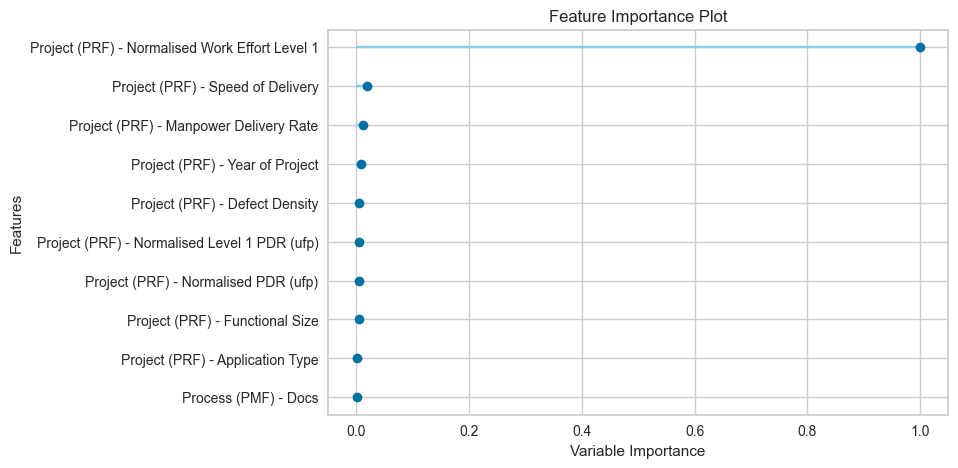

Cell executed at: 2025-05-15 17:00:36.284005


In [39]:
# Step 2: Plot feature importance

from pycaret.regression import plot_model

plot_model(model, plot='feature')

In [41]:
# 2. Use SHAP manually outside PyCaret (for any model):

import shap
import numpy as np

# 1. First, check for string columns in your dataset
df_numeric = df_encoded.drop(columns=['Project (PRF) - Normalised Work Effort']).select_dtypes(include=[np.number])

# 2. If any columns were dropped because they were non-numeric, handle them:
non_numeric_cols = df_encoded.drop(columns=['Project (PRF) - Normalised Work Effort']).columns.difference(df_numeric.columns)
if len(non_numeric_cols) > 0:
    print(f"Warning: Removing non-numeric columns for SHAP analysis: {list(non_numeric_cols)}")
    # If you need these columns, consider encoding them properly before this step

# 3. Now use only numeric columns with SHAP
explainer = shap.Explainer(model, df_numeric)
shap_values = explainer(df_numeric)

# 4. Create summary plot
shap.summary_plot(shap_values, df_numeric)

ValueError: shapes (117,) and (16,) not aligned: 117 (dim 0) != 16 (dim 0)

Cell executed at: 2025-05-15 17:01:56.461577


In [42]:
# 3. Extract feature importance from model attributes (if available)

if hasattr(model, 'feature_importances_'):
    import pandas as pd
    fi = pd.DataFrame({'Feature': df_encoded.drop(columns=['Project (PRF) - Normalised Work Effort']).columns,
                       'Importance': model.feature_importances_})
    fi = fi.sort_values('Importance', ascending=False)
    print(fi)
else:
    print("Feature importance attribute not available for this model")


Feature importance attribute not available for this model
Cell executed at: 2025-05-15 17:06:30.174744
